# IBM Capstone Project: The Battle of the Neighborhoods
## Open new Turkish Restaurant in Bucharest, Romania

## Introduction

In this project, I will determine which place is good for opening Turkish Restaurant in Bucharest, Romania 

* I will convert address data into their equivalent latitude and longitude values. 
* For Bucharest neighborhood data, I will use wikipedia , https://en.wikipedia.org/wiki/Category:Districts of Bucharest
* I will use the Foursquare API to explore Bucharest neighborhoods and get venues in neighborhoods. 
* I will use the Foursquare API to get venue ratings and likes in neighborhoods. 
* I will use the *k*-means clustering and Agglomerative algorithms to complete clustering task
* I will use the Folium library to visualize the neighborhoods, venues , clusters in Bucharest


## Table of Contents

1. <a href="#item1">Download and Explore Neigborhood Dataset</a>
2. <a href="#item2">Load and Analyze Venues of Neighborhoods in Bucharest</a>
3. <a href="#item3">Cluster Neighborhoods</a> <br> 
    3.1. <a href="#item3.1">Cluster using K - mean algorithm<a><br>
    3.2. <a href="#item3.2">Cluster using Agglomerative Clustering<a>
4. <a href="#item4">Examine Results</a>

<a id='item1'></a>
## 1. Download and Explore Neigborhood Dataset

#### Import Libraries

In [3]:
#install libraries 
!pip install geopy    
!pip install folium   
!pip install geocoder

In [4]:
#import libraries 
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt # for graphical usage 

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geocoder # to get coordinates

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library
from folium import plugins
from folium.plugins import HeatMap

# main documentation page: http://beautiful-soup-4.readthedocs.io/en/latest/
# how to use the BeautifulSoup package: https://www.youtube.com/watch?v=ng2o98k983k video
from bs4 import BeautifulSoup 
import pandas as pd
import requests

print('Libraries imported.')

Libraries imported.


#### Get geocoordinates of Bucharest, Romania

In [5]:
# get coordinates of Bucharest
bucharest_address = 'Bucharest, Romania'

geolocator = Nominatim(user_agent="bucharest_explorer")
location = geolocator.geocode(bucharest_address)
latitude = location.latitude
longitude = location.longitude
bucharest_center = [latitude, longitude ]
print('The geograpical coordinate of {} are {}, {}.'.format(bucharest_address, latitude, longitude))

The geograpical coordinate of Bucharest, Romania are 44.4361414, 26.1027202.


#### Get neighborhood data of Bucharest

I used wikiPedia, "Category:Districts of Bucharest" for getting neighborhoods of Bucharest . 

In [6]:
# Read Bucharest neighborhood data 
url = "https://en.wikipedia.org/wiki/Category:Districts of Bucharest"
source = requests.get(url).text
soup = BeautifulSoup(source,'lxml')

neighborhoodList = []

# append the data into the list
for row in soup.find_all("div", class_="mw-category")[0].findAll("li"):
    neighborhoodList.append(row.text)
    
df_neighborhood = pd.DataFrame({"Neighborhood": neighborhoodList})
print("There are {} neighborhoods in {}".format(df_neighborhood.shape[0], bucharest_address))


There are 40 neighborhoods in Bucharest, Romania


#### Get geographical coordinates of neighborhoods
I use python geocoder library to get geograpical coordinates of neighborhoods

In [9]:
# define a function to get coordinates
def get_latlng(neighborhood):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, {}'.format(neighborhood,bucharest_address))
        lat_lng_coords = g.latlng
    return lat_lng_coords

coords = [ get_latlng(neighborhood) for neighborhood in df_neighborhood["Neighborhood"].tolist() ]

df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])

# merge the coordinates into the original dataframe
df_neighborhood['Latitude'] = df_coords['Latitude']
df_neighborhood['Longitude'] = df_coords['Longitude']
print("Geographical coordinates of five neighborhoods are as below")
df_neighborhood.head()

Geographical coordinates of five neighborhoods are as below


,Neighborhood,Latitude,Longitude
0,Aviației,44.485790,26.101219
1,"Băneasa, Bucharest",44.493952,26.080518
2,"Berceni, Bucharest",44.386430,26.128490
3,Bucureștii Noi,44.480413,26.042807
4,Centrul Civic,44.434300,26.094670


#### Create Bucharest map with neighborhoods superimposed
Let's see locations of neighborhoods on map. In here, I use folium library to draw map

In [10]:
#create map of Bucharest neighborhoods using latitude and longitude values
map_bucharest= folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng,  neighborhood in zip(df_neighborhood['Latitude'], df_neighborhood['Longitude'], df_neighborhood['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bucharest)  
    
map_bucharest

<a id='item2'></a>
# 2. Load Venues and Analyze Neighborhoods in Bucharest

We will use Foursquare API for getting venues of neighborhoods

#### Explore Venues of Bucharest neighborhoods
I get venue list with 1 km distance to neighborhood's center

In [14]:
# The code was removed by Watson Studio for sharing.

In [15]:
LIMIT = 100

def getNeighborhoodVenues( latitude, longitude,neighborhood, radius=1000 ):
    venues = []
    for lat, long, neighborhood in zip(latitude, longitude ,neighborhood):

        # create the API request URL
        url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            long,
            radius, 
            LIMIT)

        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']

        # return only relevant information for each nearby venue
        for venue in results:
            venues.append((
                neighborhood,
                lat, 
                long, 
                venue['venue']['name'], 
                venue['venue']['id'], 
                venue['venue']['location']['lat'], 
                venue['venue']['location']['lng'],  
                venue['venue']['location']['distance'],  
                venue['venue']['categories'][0]['name']))
    
    # convert the venues list into a DataFrame
    venues = pd.DataFrame(venues)
    # define the column names
    venues.columns = ['Neighborhood', 'Latitude', 'Longitude', 'VenueName', 'VenueId', 'VenueLatitude', 'VenueLongitude','VenueDistance','VenueCategory']
            
    return venues 

neighborhood_venues = getNeighborhoodVenues (df_neighborhood['Latitude'], df_neighborhood['Longitude'], df_neighborhood['Neighborhood'] )

print('There are {} unique venue categories. Some of them are as below:'.format(len(neighborhood_venues['VenueCategory'].unique())))
neighborhood_venues.head()

There are 219 unique venue categories. Some of them are as below:


,Neighborhood,Latitude,Longitude,VenueName,VenueId,VenueLatitude,VenueLongitude,VenueDistance,VenueCategory
0,Aviației,44.48579,26.101219,LIDL,583956246d349d0574eb02ac,44.488396,26.094375,616,Supermarket
1,Aviației,44.48579,26.101219,Mega Image Concept Store,56348b62498e53f51a0a4e0e,44.479783,26.102568,677,Supermarket
2,Aviației,44.48579,26.101219,Flying Pig,58a2fc95d0bb3e516a2363b7,44.479454,26.102837,716,Burger Joint
3,Aviației,44.48579,26.101219,Starbucks,525fd077498eed1c5a52c1d6,44.478522,26.102503,815,Coffee Shop
4,Aviației,44.48579,26.101219,Mega Image,4eb5452b30f8d0f18c41dfec,44.487255,26.092758,691,Supermarket


In [18]:
print('Top 10 distinct venue counts are as below')
neighborhood_venues[['VenueId','VenueCategory']].drop_duplicates().groupby('VenueCategory').count()[['VenueId']].sort_values(by=['VenueId'], ascending=False)[:10]

Top 10 distinct venue counts are as below


,VenueId
VenueCategory,
Café,69
Restaurant,69
Coffee Shop,59
Italian Restaurant,57
Supermarket,54
Pizza Place,50
Gym,41
Hotel,41
Romanian Restaurant,40


#### Filter restaurants out of all venues
Let's filter venues and get only restaurants 

In [39]:
restaurant_list =['Restaurant', 'Burger Joint','Café','Fried Chicken Joint','Pizza Place']
turkish_restaurant_list = ['Turkish Restaurant', 'Doner Restaurant']

# Filter restaurants 
    
neighborhood_venues['RestFlag']=False
for restCat in restaurant_list:
    neighborhood_venues['RestFlag'] = neighborhood_venues['RestFlag'] | neighborhood_venues['VenueCategory'].str.contains(restCat)
    
neighborhood_restaurants = neighborhood_venues[neighborhood_venues['RestFlag'] == True].iloc[:,:-1]
turkish_restaurants = neighborhood_restaurants[ neighborhood_restaurants['VenueCategory'].isin(turkish_restaurant_list) ]
other_restaurants = neighborhood_restaurants[ ~neighborhood_restaurants['VenueCategory'].isin(turkish_restaurant_list) ]

print('Total number of restaurants:', len(neighborhood_restaurants['VenueId'].unique()))
print('Total number of Turkish restaurants:', len(turkish_restaurants['VenueId'].unique()))
print('Percentage of Turkish restaurants: {:.2f}%'.format(len(turkish_restaurants['VenueId'].unique()) / len(neighborhood_restaurants['VenueId'].unique()) * 100))


Total number of restaurants: 503
Total number of Turkish restaurants: 20
Percentage of Turkish restaurants: 3.98%


19 neighborhoods do not have any Turkish restaurant


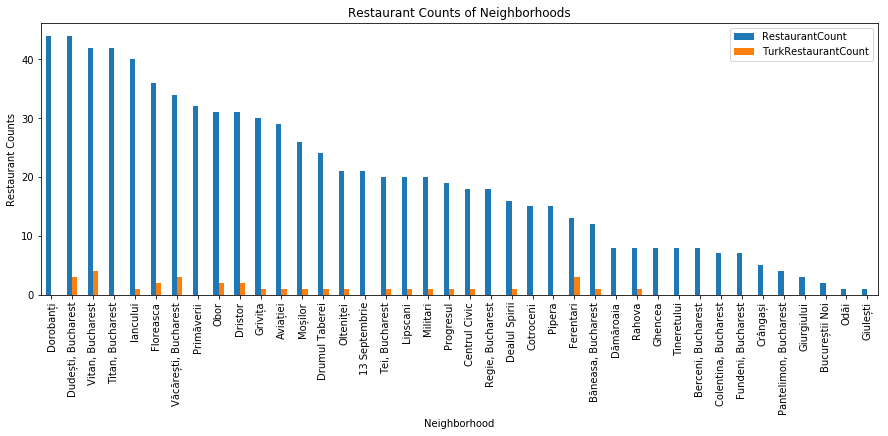

In [26]:
# get counts of restaurants in each Neighborhood
df_rest_counts =  neighborhood_restaurants.groupby(['Neighborhood']).count().rename(columns={"VenueCategory": "RestaurantCount"})[['RestaurantCount']]

#find neighborhoods that does not have any restaurant 
noRestList = list(set(neighborhood_venues['Neighborhood']) - set(neighborhood_restaurants['Neighborhood']))

#if exists , append neighborhoods without any restaurant to df_rest_counts
if noRestList != []:
    df_rest_counts = df_rest_counts.append (pd.DataFrame( {'Neighborhood' : noRestList  , 'RestaurantCount': [0] * len(noRestList) } ).set_index('Neighborhood'))

df_rest_counts.reset_index(inplace=True)

#####
# get counts of Turkish restaurants in each Neighborhood
df_turk_rest_counts =  turkish_restaurants.groupby(['Neighborhood']).count().rename(columns={"VenueCategory": "TurkRestaurantCount"})[['TurkRestaurantCount']]

#find neighborhoods that does not have any restaurant 
noRestList = list(set(neighborhood_venues['Neighborhood']) - set(turkish_restaurants['Neighborhood']))

#if exists , append neighborhoods without any restaurant to df_rest_counts
if noRestList != []:
    df_turk_rest_counts = df_turk_rest_counts.append (pd.DataFrame( {'Neighborhood' : noRestList  , 'TurkRestaurantCount': [0] * len(noRestList) } ).set_index('Neighborhood'))

df_turk_rest_counts.reset_index(inplace=True)
df_rest_counts= df_rest_counts.merge(df_turk_rest_counts).set_index('Neighborhood')
df_rest_counts= df_rest_counts.sort_values(by=['RestaurantCount'],ascending =False)

print('{} neighborhoods do not have any Turkish restaurant'.format(len(noRestList)))
######
#Draw graph
df_rest_counts[['RestaurantCount','TurkRestaurantCount']].plot(kind='bar',figsize=(15,5))
plt.title('Restaurant Counts of Neighborhoods')
plt.xlabel('Neighborhood')
plt.ylabel('Restaurant Counts')
plt.show()



We can see from the Graph :
* Dorobanti is the neihgborhood having most restaurants , but no Tukish restaurant
* Odai and Gluesti are neihgborhoods having least number of restaurants
* 19 neihgborhoods do not have any Turkish restaurant. we can choose one of these to open resaturant. To filter more let's continue

#### Get the restaurant's overall rating

I used Foursquare API for getting likes and rates of restaurants 

In [40]:
def getVenueRaitings(venues):
    
    raitings = []
    likes =[]
    for venueId in venues:

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venueId, CLIENT_ID, CLIENT_SECRET, VERSION)
        result = requests.get(url).json()
        try:
            rating = result['response']['venue']['rating']
            likes = result['response']['venue']['likes']['count']
        except:
            rating = None
            likes = None
        
        raitings.append((venueId, rating,likes))
 
    # convert the venues list into a DataFrame
    rating = pd.DataFrame(raitings)
    # define the column names
    rating.columns = ['VenueId', 'VenueRating','VenueLikes']

    return rating    

restaurants_raitings = getVenueRaitings(neighborhood_restaurants['VenueId'].drop_duplicates())
restaurants_raitings.head()

,VenueId,VenueRating,VenueLikes
0,58a2fc95d0bb3e516a2363b7,8.4,22.0
1,53623e44498ed583ede334f5,8.2,130.0
2,58bbf8764f1069627380fed5,7.7,21.0
3,55b8a459498efbbb6ca3526d,7.7,8.0
4,59162d2d2be42556981e1e4a,7.6,67.0


In [42]:
#merge raitings to restaurants 
neighborhood_restaurants = neighborhood_restaurants.merge(restaurants_raitings)
neighborhood_restaurants.head()

,Neighborhood,Latitude,Longitude,VenueName,VenueId,VenueLatitude,VenueLongitude,VenueDistance,VenueCategory,VenueRating,VenueLikes
0,Aviației,44.485790,26.101219,Flying Pig,58a2fc95d0bb3e516a2363b7,44.479454,26.102837,716,Burger Joint,8.4,22.0
1,Floreasca,44.476308,26.103289,Flying Pig,58a2fc95d0bb3e516a2363b7,44.479454,26.102837,351,Burger Joint,8.4,22.0
2,Aviației,44.485790,26.101219,trickSHOT,53623e44498ed583ede334f5,44.478378,26.103135,838,Restaurant,8.2,130.0
3,Floreasca,44.476308,26.103289,trickSHOT,53623e44498ed583ede334f5,44.478378,26.103135,230,Restaurant,8.2,130.0
4,Aviației,44.485790,26.101219,Manufaktura by Doncafé,58bbf8764f1069627380fed5,44.478429,26.104004,848,Café,7.7,21.0


In [43]:
#merge raitings to turkish restaurants 
turkish_restaurants = turkish_restaurants.merge(restaurants_raitings)
turkish_restaurants.head(5)

,Neighborhood,Latitude,Longitude,VenueName,VenueId,VenueLatitude,VenueLongitude,VenueDistance,VenueCategory,VenueRating,VenueLikes
0,Aviației,44.485790,26.101219,Istanbul Taksim,55acc94f498e0a64af6b19af,44.478560,26.103505,825,Turkish Restaurant,7.4,12.0
1,Floreasca,44.476308,26.103289,Istanbul Taksim,55acc94f498e0a64af6b19af,44.478560,26.103505,251,Turkish Restaurant,7.4,12.0
2,"Băneasa, Bucharest",44.493952,26.080518,Shaormeria Băneasa,5137a298e4b0523475c45b54,44.494460,26.080462,56,Doner Restaurant,7.3,39.0
3,Centrul Civic,44.434300,26.094670,Dristor Kebap,4dc58dd7887717c8802694a1,44.429973,26.100381,661,Doner Restaurant,7.9,465.0
4,Lipscani,44.432155,26.104057,Dristor Kebap,4dc58dd7887717c8802694a1,44.429973,26.100381,379,Doner Restaurant,7.9,465.0


#### Show restaurants on head map 

Let's crete a map showing heatmap / density of restaurants and try to extract some meaningfull info from that. Also, let's show borders of Bucharest on our map and a few circles indicating distance of 2km, 4km, 6km and 10km from Bucharest center

<font color='red'>Red</font> markers are <font color='red'> Turkish </font> restaurants

<font color='Blue'>Blue</font> markers are Turkish restaurants with <font color='blue'> rating less than 7  </font> restaurants


In [63]:
bucharest_center = [latitude, longitude]
map_restaurant= folium.Map(location=bucharest_center, zoom_start=12)
df_neighborhood_noturkrest = df_neighborhood[df_neighborhood['Neighborhood'].isin(noRestList)]

folium.TileLayer('cartodbpositron').add_to(map_bucharest) 
HeatMap(neighborhood_restaurants[['VenueLatitude','VenueLongitude']]).add_to(map_restaurant)
folium.Marker(bucharest_center).add_to(map_bucharest)
folium.Circle(bucharest_center, radius=2000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(bucharest_center, radius=4000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(bucharest_center, radius=6000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(bucharest_center, radius=10000, fill=False, color='black').add_to(map_restaurant)
for lat, lon, neig, name in zip(turkish_restaurants['VenueLatitude'], turkish_restaurants['VenueLongitude'], turkish_restaurants['Neighborhood'], turkish_restaurants['VenueName']):
    label = folium.Popup(str(name) + ' - ' + str(neig), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_restaurant)
       
raiting_lt_7 = turkish_restaurants[turkish_restaurants['VenueRating'] <7]
for lat, lon, neig, name in zip(raiting_lt_7['VenueLatitude'], raiting_lt_7['VenueLongitude'], raiting_lt_7['Neighborhood'], raiting_lt_7['VenueName']):
    label = folium.Popup(str(name) + ' - ' + str(neig), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_restaurant)        
map_restaurant

From heat map , we can see that there are 
* Too many restaurants in 4 km to the center 
* Enough restaurants between 4-6 km to the center 
* There are <b> not many </b> restaurants after <b> 6 km to center </b> 
* <b> Turkish restaurants are located in South, North , East, between 2-4 Km distance around center </b>
* There are <b> not Turkish Restaurants in West Part.</b>
* Some Turkish restaurants gets bad points. That means people does not prefer these restaurant too much and any turkish restaurant may be opened around

#### Show neighborhoods which has no Turkish restaurant on head map 

<font color='Cyan'>Cyan</font> markers are Neigborhoods <font color='Cyan'> without any turkish </font> restaurants

In [58]:
bucharest_center = [latitude, longitude]
map_restaurant= folium.Map(location=bucharest_center, zoom_start=12)

df_neighborhood_noturkrest = df_neighborhood[df_neighborhood['Neighborhood'].isin(noRestList)]

folium.TileLayer('cartodbpositron').add_to(map_bucharest) 
HeatMap(neighborhood_restaurants[['VenueLatitude','VenueLongitude']]).add_to(map_restaurant)
folium.Marker(bucharest_center).add_to(map_bucharest)
folium.Circle(bucharest_center, radius=2000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(bucharest_center, radius=4000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(bucharest_center, radius=6000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(bucharest_center, radius=10000, fill=False, color='black').add_to(map_restaurant)
for lat, lon, neig in zip(df_neighborhood_noturkrest['Latitude'], df_neighborhood_noturkrest['Longitude'], df_neighborhood_noturkrest['Neighborhood']):
    label = folium.Popup(str(neig), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='cyan',
        fill=True,
        fill_color='cyan',
        fill_opacity=0.7).add_to(map_restaurant)
map_restaurant

<a id='item3'></a>
# 3. Cluster Neigborhoods

<a id='item3.1'></a>
### 3.1. Cluster using K - mean algorithm

Let's first transpose neighborhoods vs restaurant counts data.Then we will use this data for clustering  

In [94]:
#### Analyse each neighborhood
# one hot encoding
onehot = pd.get_dummies(neighborhood_venues[['VenueCategory']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
onehot['Neighborhood'] = neighborhood_venues['Neighborhood']

venues_grouped = onehot.groupby(["Neighborhood"]).sum().reset_index()

# move neighborhood column to the first column and filter only restaurant columns 
fixed_columns =['Neighborhood'] + list(neighborhood_venues['VenueCategory'].unique())
venues_grouped = venues_grouped[fixed_columns]

print("{}  neighborhoods' restaurant category are shown in {} columns as below".format(venues_grouped.shape[0],venues_grouped.shape[1]-1))
venues_grouped.head()

40  neighborhoods' restaurant category are shown in 219 columns as below


,Neighborhood,Supermarket,Burger Joint,Coffee Shop,Dessert Shop,Beer Garden,Restaurant,Roof Deck,Gym / Fitness Center,Grocery Store,Shopping Mall,Salad Place,Hotel,Candy Store,Pie Shop,Café,Vietnamese Restaurant,Bakery,Salon / Barbershop,Bookstore,Italian Restaurant,Turkish Restaurant,Sushi Restaurant,Clothing Store,Steakhouse,Toy / Game Store,Sandwich Place,Pizza Place,Lebanese Restaurant,Middle Eastern Restaurant,Casino,Spanish Restaurant,Event Space,Lounge,Chinese Restaurant,Romanian Restaurant,Pub,Stadium,Snack Place,Tennis Stadium,Health & Beauty Service,Business Service,Mongolian Restaurant,Food Court,Eastern European Restaurant,Men's Store,Cocktail Bar,Electronics Store,Indoor Play Area,Doner Restaurant,Vegetarian / Vegan Restaurant,Lake,Park,Nightclub,Tunnel,Theme Restaurant,Farmers Market,Bed & Breakfast,Music Venue,Food & Drink Shop,Spa,Nature Preserve,Gym,Fruit & Vegetable Store,Fast Food Restaurant,Pharmacy,Soccer Field,Jewelry Store,Metro Station,Department Store,Gas Station,Light Rail Station,Korean Restaurant,Dog Run,Gastropub,Indie Theater,Outdoor Sculpture,Theater,Monastery,Bistro,Skating Rink,Ice Cream Shop,Historic Site,Used Bookstore,Chocolate Shop,Palace,Bar,Plaza,Art Museum,Beer Bar,Hostel,Music Store,Concert Hall,Wine Bar,Tea Room,Hookah Bar,Cosmetics Shop,Rock Club,Swiss Restaurant,Art Gallery,History Museum,Boutique,Mediterranean Restaurant,Hotel Bar,Church,Hardware Store,Fried Chicken Joint,Discount Store,Arts & Crafts Store,Bus Station,Auto Dealership,Furniture / Home Store,Gift Shop,Tennis Court,Jazz Club,Accessories Store,Opera House,Market,Pedestrian Plaza,Indian Restaurant,Pool,Garden,Indie Movie Theater,Australian Restaurant,Cafeteria,Bike Rental / Bike Share,Buffet,Scenic Lookout,Cupcake Shop,French Restaurant,Climbing Gym,Soccer Stadium,Bowling Alley,Athletics & Sports,Smoke Shop,Convenience Store,Outlet Mall,Women's Store,Mobile Phone Shop,Flower Shop,Japanese Restaurant,Fish Market,Juice Bar,Scandinavian Restaurant,Cheese Shop,Asian Restaurant,Modern European Restaurant,Creperie,Seafood Restaurant,German Restaurant,Brewery,Molecular Gastronomy Restaurant,Wine Shop,Drugstore,Auto Workshop,Pet Store,Multiplex,Eye Doctor,Skate Park,Greek Restaurant,Bus Line,Movie Theater,Kids Store,Water Park,American Restaurant,Health Food Store,Diner,Science Museum,ATM,Lingerie Store,Cable Car,Sports Club,Boxing Gym,Museum,Food Truck,Kebab Restaurant,Exhibit,Public Art,Donut Shop,Tattoo Parlor,Sporting Goods Shop,Gourmet Shop,Hospital,Irish Pub,Camera Store,BBQ Joint,Hungarian Restaurant,Karaoke Bar,Beach,Auto Garage,Shoe Store,Food,Bagel Shop,Go Kart Track,Falafel Restaurant,Track,Gym Pool,Recreation Center,Bike Shop,Memorial Site,Basketball Court,Paper / Office Supplies Store,Pool Hall,Sports Bar,Baby Store,Comfort Food Restaurant,Taco Place,Fish & Chips Shop,Watch Shop,Tram Station,Recording Studio,Breakfast Spot,Soup Place,Circus,Dance Studio,Pet Café,Leather Goods Store,Gaming Cafe,Cultural Center,IT Services
0,13 Septembrie,2,0,3,0,0,5,0,2,0,0,0,3,0,0,3,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,2,0,2,3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1,1,1,4,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,1,1,1,1,1,0,0,0,0,0,0,0,0
1,Aviației,4,3,4,2,1,5,1,1,1,1,1,4,1,1,4,1,5,1,1,1,1,2,2,3,1,1,4,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"Berceni, Bucharest",0,0,1,0,1,0,0,2,2,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,

#### Find k for k-means algorithm

We will use unsupervised k-means cluster machine leraning algorithm to find neighborhood clusters. First we should find which k value we should use.<br>
In order to find k value, we will use <b> elbow method<b>

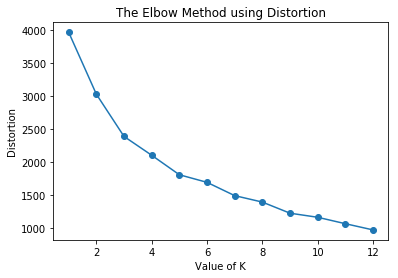

In [95]:
from sklearn.cluster import KMeans 
import matplotlib.pyplot as plt  

# calculate distortion for a range of number of cluster
distortions = []
K = 13
neighborhood_clustering = venues_grouped.drop(["Neighborhood"], axis=1)

for k in range(1, K):
    km = KMeans(n_clusters=k)
    km.fit(neighborhood_clustering)
    distortions.append(km.inertia_)
    
# plot
plt.plot(range(1, K), distortions, marker='o')
plt.xlabel('Value of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion') 
plt.show()    

#### Cluster and find similarities between neighborhoods

Accoring to above elbow graph , I get k =6

In [107]:
# fit our data to k-means and find clusters 
kclusters = 7

# run k-means clustering
kmeans = KMeans(init="k-means++", n_clusters=kclusters, n_init=12).fit(neighborhood_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([1, 6, 0, 0, 0, 2, 0, 1, 0, 1, 5, 4, 4, 3, 0, 0, 6, 0, 0, 0, 0, 1,
       4, 2, 2, 2, 4, 0, 4, 0, 0, 1, 1, 0, 1, 2, 0, 5, 3, 4], dtype=int32)

In [108]:
# assign labels to our neighborhood dataframe
merged = venues_grouped.copy()

# add clustering labels
merged["NeighborhoodCluster"] = kmeans.labels_

df_merged = merged[['Neighborhood','NeighborhoodCluster']].merge(df_neighborhood)
df_merged.head()


,Neighborhood,NeighborhoodCluster,Latitude,Longitude
0,13 Septembrie,1,44.424978,26.083313
1,Aviației,6,44.485790,26.101219
2,"Berceni, Bucharest",0,44.386430,26.128490
3,Bucureștii Noi,0,44.480413,26.042807
4,"Băneasa, Bucharest",0,44.493952,26.080518


#### Visualize Clusters

In [110]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
for lat, lon, poi, cluster in zip(df_merged['Latitude'], df_merged['Longitude'], df_merged['Neighborhood'], df_merged['NeighborhoodCluster']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<a id='item3.2'></a>
### 3.2. Cluster using Agglomerative Clustering

In [99]:
# one hot encoding
onehot = pd.get_dummies(neighborhood_venues[['VenueCategory']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
onehot['Neighborhood'] = neighborhood_venues['Neighborhood']

venues_grouped = onehot.groupby(["Neighborhood"]).sum().reset_index()

# move neighborhood column to the first column and filter only restaurant columns 
fixed_columns =['Neighborhood'] + list(neighborhood_venues['VenueCategory'].unique())
venues_grouped = venues_grouped[fixed_columns]

print("{}  neighborhoods' restaurant category are shown in {} columns as below".format(venues_grouped.shape[0],venues_grouped.shape[1]-1))
venues_grouped.head()

40  neighborhoods' restaurant category are shown in 219 columns as below


,Neighborhood,Supermarket,Burger Joint,Coffee Shop,Dessert Shop,Beer Garden,Restaurant,Roof Deck,Gym / Fitness Center,Grocery Store,Shopping Mall,Salad Place,Hotel,Candy Store,Pie Shop,Café,Vietnamese Restaurant,Bakery,Salon / Barbershop,Bookstore,Italian Restaurant,Turkish Restaurant,Sushi Restaurant,Clothing Store,Steakhouse,Toy / Game Store,Sandwich Place,Pizza Place,Lebanese Restaurant,Middle Eastern Restaurant,Casino,Spanish Restaurant,Event Space,Lounge,Chinese Restaurant,Romanian Restaurant,Pub,Stadium,Snack Place,Tennis Stadium,Health & Beauty Service,Business Service,Mongolian Restaurant,Food Court,Eastern European Restaurant,Men's Store,Cocktail Bar,Electronics Store,Indoor Play Area,Doner Restaurant,Vegetarian / Vegan Restaurant,Lake,Park,Nightclub,Tunnel,Theme Restaurant,Farmers Market,Bed & Breakfast,Music Venue,Food & Drink Shop,Spa,Nature Preserve,Gym,Fruit & Vegetable Store,Fast Food Restaurant,Pharmacy,Soccer Field,Jewelry Store,Metro Station,Department Store,Gas Station,Light Rail Station,Korean Restaurant,Dog Run,Gastropub,Indie Theater,Outdoor Sculpture,Theater,Monastery,Bistro,Skating Rink,Ice Cream Shop,Historic Site,Used Bookstore,Chocolate Shop,Palace,Bar,Plaza,Art Museum,Beer Bar,Hostel,Music Store,Concert Hall,Wine Bar,Tea Room,Hookah Bar,Cosmetics Shop,Rock Club,Swiss Restaurant,Art Gallery,History Museum,Boutique,Mediterranean Restaurant,Hotel Bar,Church,Hardware Store,Fried Chicken Joint,Discount Store,Arts & Crafts Store,Bus Station,Auto Dealership,Furniture / Home Store,Gift Shop,Tennis Court,Jazz Club,Accessories Store,Opera House,Market,Pedestrian Plaza,Indian Restaurant,Pool,Garden,Indie Movie Theater,Australian Restaurant,Cafeteria,Bike Rental / Bike Share,Buffet,Scenic Lookout,Cupcake Shop,French Restaurant,Climbing Gym,Soccer Stadium,Bowling Alley,Athletics & Sports,Smoke Shop,Convenience Store,Outlet Mall,Women's Store,Mobile Phone Shop,Flower Shop,Japanese Restaurant,Fish Market,Juice Bar,Scandinavian Restaurant,Cheese Shop,Asian Restaurant,Modern European Restaurant,Creperie,Seafood Restaurant,German Restaurant,Brewery,Molecular Gastronomy Restaurant,Wine Shop,Drugstore,Auto Workshop,Pet Store,Multiplex,Eye Doctor,Skate Park,Greek Restaurant,Bus Line,Movie Theater,Kids Store,Water Park,American Restaurant,Health Food Store,Diner,Science Museum,ATM,Lingerie Store,Cable Car,Sports Club,Boxing Gym,Museum,Food Truck,Kebab Restaurant,Exhibit,Public Art,Donut Shop,Tattoo Parlor,Sporting Goods Shop,Gourmet Shop,Hospital,Irish Pub,Camera Store,BBQ Joint,Hungarian Restaurant,Karaoke Bar,Beach,Auto Garage,Shoe Store,Food,Bagel Shop,Go Kart Track,Falafel Restaurant,Track,Gym Pool,Recreation Center,Bike Shop,Memorial Site,Basketball Court,Paper / Office Supplies Store,Pool Hall,Sports Bar,Baby Store,Comfort Food Restaurant,Taco Place,Fish & Chips Shop,Watch Shop,Tram Station,Recording Studio,Breakfast Spot,Soup Place,Circus,Dance Studio,Pet Café,Leather Goods Store,Gaming Cafe,Cultural Center,IT Services
0,13 Septembrie,2,0,3,0,0,5,0,2,0,0,0,3,0,0,3,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,2,0,2,3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1,1,1,4,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,1,1,1,1,1,0,0,0,0,0,0,0,0
1,Aviației,4,3,4,2,1,5,1,1,1,1,1,4,1,1,4,1,5,1,1,1,1,2,2,3,1,1,4,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"Berceni, Bucharest",0,0,1,0,1,0,0,2,2,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,

In [100]:
# create a new dataframe with most common venue catrgories
def return_most_common_venues(row, num_top_venues):
    row_categories = row
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

columns = ['Neighborhood','Total Number of Restaurants']
indicators = ['st', 'nd', 'rd']
# create columns according to number of top venues

for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Restaurant'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Restaurant'.format(ind+1))

# create a new dataframe
venues_most = pd.DataFrame(columns = columns)

for ind in range(venues_grouped.shape[0]):
    venues_most.loc[ind, 'Neighborhood'] = venues_grouped.iloc[ind].Neighborhood
    venues_most.loc[ind, 'Total Number of Restaurants'] = venues_grouped.iloc[ind,1:].sum()
    venues_most.iloc[ind, 2:] = return_most_common_venues(venues_grouped.iloc[ind, 1:], num_top_venues)

venues_most.head()

,Neighborhood,Total Number of Restaurants,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant,6th Most Common Restaurant,7th Most Common Restaurant,8th Most Common Restaurant,9th Most Common Restaurant,10th Most Common Restaurant
0,13 Septembrie,73,Restaurant,Plaza,Hotel,Coffee Shop,Café,Pub,Romanian Restaurant,Bistro,Tea Room,Gym / Fitness Center
1,Aviației,79,Restaurant,Bakery,Supermarket,Pizza Place,Hotel,Café,Coffee Shop,Burger Joint,Steakhouse,Lebanese Restaurant
2,"Berceni, Bucharest",29,Pizza Place,Eastern European Restaurant,Gym,Gym / Fitness Center,Grocery Store,Farmers Market,Nature Preserve,Electronics Store,Italian Restaurant,Bakery
3,Bucureștii Noi,12,Supermarket,Gym,Dog Run,Korean Restaurant,Light Rail Station,Gas Station,Department Store,Metro Station,Park,Restaurant
4,"Băneasa, Bucharest",29,Italian Restaurant,Romanian Restaurant,Café,Grocery Store,Hotel,Lake,Pizza Place,Middle Eastern Restaurant,Indoor Play Area,Doner Restaurant


#### Cluster and find similarities between neighborhoods

I will use hierarchical agglomerative clustering method to compare neighborhoods among neighborhoods

First, find the number of clusters. Let's use scipy library to create the dendrograms for our dataset

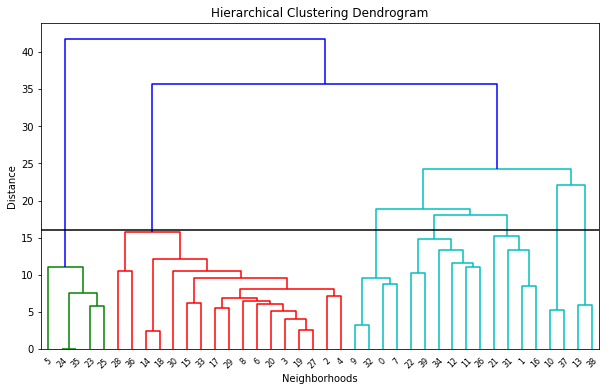

In [113]:
import scipy.cluster.hierarchy as shc

data = venues_grouped.iloc[:,3:]
plt.figure(figsize=(10, 6))   
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Neighborhoods')
plt.ylabel('Distance')
plt.axhline(y=16, c='k')
dend = shc.dendrogram(shc.linkage(data, method='ward'))

According to the above graph, I decide to separate our neighborhoods into 6 clusters (cut at distance of 18, horizontal black line). 
I will use the hierarchical agglomerative clustering of the sklearn.cluster library to cluster these neighborhoods.

In [133]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=7, affinity='euclidean', linkage='ward')  
clusterresult = cluster.fit_predict(data)

venues_most['NeighborhoodCluster'] = clusterresult
venues_cluster= df_neighborhood[['Neighborhood','Latitude','Longitude']].merge(venues_most[['Neighborhood','NeighborhoodCluster']])
venues_cluster.head()


,Neighborhood,Latitude,Longitude,Total Number of Restaurants,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant,6th Most Common Restaurant,7th Most Common Restaurant,8th Most Common Restaurant,9th Most Common Restaurant,10th Most Common Restaurant,NeighborhoodCluster
0,Aviației,44.485790,26.101219,79,Restaurant,Bakery,Supermarket,Pizza Place,Hotel,Café,Coffee Shop,Burger Joint,Steakhouse,Lebanese Restaurant,2
1,"Băneasa, Bucharest",44.493952,26.080518,29,Italian Restaurant,Romanian Restaurant,Café,Grocery Store,Hotel,Lake,Pizza Place,Middle Eastern Restaurant,Indoor Play Area,Doner Restaurant,0
2,"Berceni, Bucharest",44.386430,26.128490,29,Pizza Place,Eastern European Restaurant,Gym,Gym / Fitness Center,Grocery Store,Farmers Market,Nature Preserve,Electronics Store,Italian Restaurant,Bakery,0
3,Bucureștii Noi,44.480413,26.042807,12,Supermarket,Gym,Dog Run,Korean Restaurant,Light Rail Station,Gas Station,Department Store,Metro Station,Park,Restaurant,0
4,Centrul Civic,44.434300,26.094670,100,Coffee Shop,Hotel,Romanian Restaurant,Theater,Café,Wine Bar,Gastropub,Roof Deck,Bookstore,Ice Cream Shop,1


In [134]:
kclusters= 7
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
for lat, lon, poi, cluster in zip(venues_cluster['Latitude'], venues_cluster['Longitude'], venues_cluster['Neighborhood'], venues_cluster['NeighborhoodCluster']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [143]:
print(len(universityList)   )

240
